In [9]:
%reset
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

tf.reset_default_graph()

def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='latin1')
    return d

data1 = unpickle('cifar-10-batches-py/data_batch_1')
data2 = unpickle('cifar-10-batches-py/data_batch_2')
data3 = unpickle('cifar-10-batches-py/data_batch_3')
data4 = unpickle('cifar-10-batches-py/data_batch_4')
data5 = unpickle('cifar-10-batches-py/data_batch_5')

def convert_images(raw):
    '''
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    '''

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images

batch_size = 128
training_epochs = 120
display_step = 10

X_train = np.concatenate((data1['data'], data2['data'], data3['data'], data4['data'], data5['data']), axis=0)
X_train = convert_images(X_train)

test = unpickle('cifar-10-batches-py/test_batch')
X_test = test['data'] 
X_test = convert_images(X_test)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, X_train.shape[1],X_train.shape[2],X_train.shape[3] ])
x_origin = x

W_e_conv1 = weight_variable([5, 5, 3, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

code_layer = h_e_conv2
print("code layer shape : %s" % h_e_conv2.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")
output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 16, 16, 16])
h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, W_d_conv1, output_shape_d_conv1))

W_d_conv2 = weight_variable([5, 5, 3, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")
output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 32, 32, 3])
h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

x_reconstruct = h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())

cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)


with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    total_batch = int(X_train.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            offset = (i * batch_size) % (X_train.shape[0] - batch_size)

            batch_xs = X_train[offset:(offset + batch_size)]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    # # Applying encode and decode over test set
    re_image, test_code = sess.run([x_reconstruct, code_layer], feed_dict={x: X_test})


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
code layer shape : (?, 8, 8, 32)
reconstruct layer shape : (?, 32, 32, 3)
Epoch: 0001 cost= 0.011721786
Epoch: 0011 cost= 0.002384938
Epoch: 0021 cost= 0.002643182
Epoch: 0031 cost= 0.002069927
Epoch: 0041 cost= 0.001917618
Epoch: 0051 cost= 0.001992033
Epoch: 0061 cost= 0.001794793
Epoch: 0071 cost= 0.002017039
Epoch: 0081 cost= 0.002310293
Epoch: 0091 cost= 0.001853089
Epoch: 0101 cost= 0.002082475
Epoch: 0111 cost= 0.001855912
Optimization Finished!


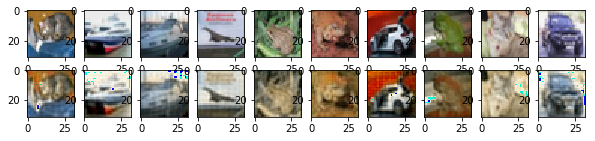

In [10]:
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        a[0][i].imshow((X_test[i]*255).astype(np.uint8))
        a[1][i].imshow((re_image[i]*255).astype(np.uint8))
    plt.show()

# notMNIST

In [11]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f, encoding='latin1')
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    

image_size = 28
num_labels = 10
num_channels = 1 # grayscale



train_dataset = train_dataset.reshape(200000, 28*28)
test_dataset = test_dataset.reshape(10000, 28*28)

print('train shape {}'.format(train_dataset.shape))
print('test shape {}'.format(test_dataset.shape))

Training set (200000, 28, 28) (200000,)
Test set (10000, 28, 28) (10000,)
train shape (200000, 784)
test shape (10000, 784)


Epoch: 0001 cost= 0.094679423
Epoch: 0002 cost= 0.077470593
Epoch: 0003 cost= 0.069177479
Epoch: 0004 cost= 0.064229690
Epoch: 0005 cost= 0.059550110
Optimization Finished!


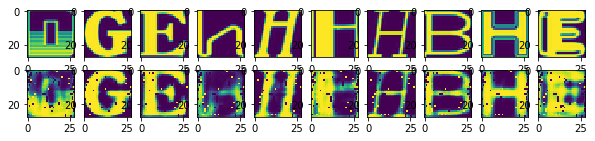

In [15]:
# Visualize decoder setting
# Parameters
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(train_dataset)
train_dataset = scaler.transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

#print(train_dataset)

learning_rate = 0.01
training_epochs = 5
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    total_batch = int(train_dataset.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            #batch_xs, batch_ys = mnist.train.next_batch(batch_size)  
            batch_xs = train_dataset[i*batch_size:(i+1)*batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # # Applying encode and decode over test set
    encode_decode = sess.run(y_pred, feed_dict={X: test_dataset[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(test_dataset[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()